In [1]:
# core stuff for gravann
import gravann
import numpy as np
import pickle as pk
import os
import pykep
from collections import deque

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device) 


Will use device  cpu


/home/moritz/Gadgets/anns4geodesy/gravann/_utils.py:80: UserWarning: Error enabling CUDA. cuda.is_available() returned False. CPU will be used.
  warnings.warn(


In [2]:
from spiceypy import spiceypy as spice
from spiceypy.utils.exceptions import SpiceNOTDISJOINT

In [3]:
from calendar import month_abbr
from astropy.time import Time, TimeDelta
import datetime

In [4]:
# Other bennu related stuff
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/bennu_v15.tpc")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/pck00010.tpc")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_v14.tf")
# leap seconds kernel
spice.furnsh('/home/moritz/Downloads/naif0012.tls')
spice.furnsh('/home/moritz/Downloads/pck00010.tpc')

In [5]:
# Other Solar system Ephemerides
spice.furnsh("/home/moritz/Downloads/de430.bsp")
# Bennu Ephemerides
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/bennu_refdrmc_v1.bsp")
# Bennu DSK
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/bennu_g_00880mm_alt_obj_0000n00000_v020.bds")

In [6]:
# Osiris Rex
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_160909_171201_170830_od023_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_170501_180710_171005_od027_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_170923_180710_180125_od030_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_170923_180710_180321_od031_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_180301_181201_180921_od044_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_180801_190302_181218_od077_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_181203_190302_190104_od085_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_181231_190305_190215_od099_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190201_190327_190315_od110_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190301_190424_190412_od125_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190401_190522_190508_od137_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190426_190605_190522_od143_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190511_190619_190603_od148_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190601_190625_190614_od154_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190612_190917_190730_od170_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190712_190917_190814_od175_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190809_191008_190923_od182_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190809_191015_191004_od187_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_190915_191029_191014_od191_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_191001_191105_191021_od194_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_191015_191112_191030_od198_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_191027_200101_191104_od200_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_191101_200225_200214_od223_v1.bsp")
spice.furnsh("/home/moritz/Downloads/osiris_rex_spice/orx_200127_200324_200311_od232_v1.bsp")

In [7]:
bennu_id = spice.bodn2c("Bennu")
sun_id = spice.bodn2c("Sun")

In [8]:
monthnames = [elem.upper() for elem in month_abbr]
def dateToIso(noniso: str):
    year, textmonth, day, clock = noniso.split()
    month = monthnames.index(textmonth)
    return year+"-"+str(month)+"-"+day+" "+clock

In [9]:
# Encoding choosen
encoding = gravann.direct_encoding()

# For "normal" training
model = gravann.init_network(encoding, model_type="siren")

In [10]:
model.load_state_dict(torch.load("models/siren_acc_bennu_no_pebbles.mdl", map_location=torch.device('cpu')))

<All keys matched successfully>

Sampling points...: 3126it [00:00, 7874.61it/s]             


<IPython.core.display.Javascript object>


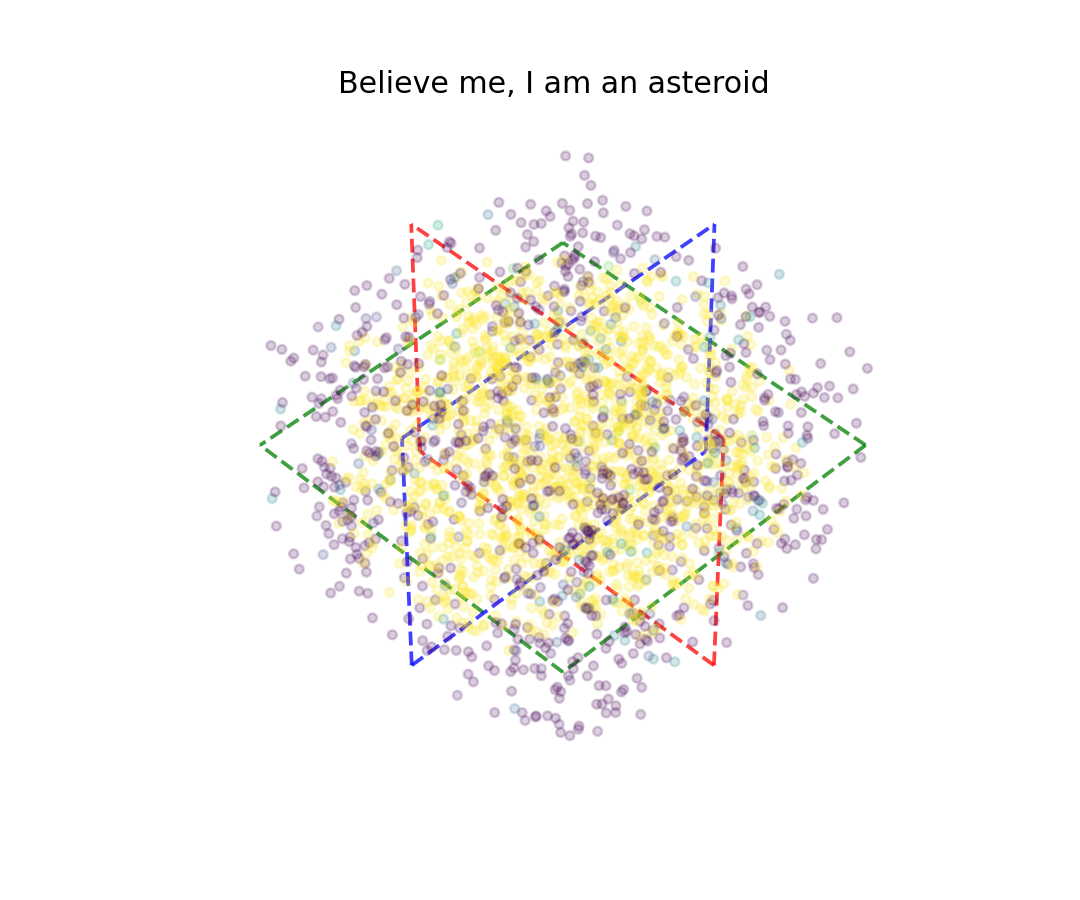

Text(0.5, 0.92, 'Believe me, I am an asteroid')

In [11]:
gravann.plot_model_rejection(model, encoding, views_2d=False, N=2500, progressbar=True, c=10)
plt.title("Believe me, I am an asteroid")

In [12]:
L_units = 352.1486930549145
T_units = 2987.9522951342647
a_units = L_units / T_units**2

integrator = gravann.ACC_trap
N_integration = 30000

In [13]:
def acceleration(spice_id: int, t: Time, dt: float):
    def vel(x: Time):
        v = np.array(spice.spkez(spice_id, spice.str2et(x.iso), "J2000", abcorr="NONE", obs=bennu_id)[0][3:])
        return v
    
    h = datetime.timedelta(seconds=dt)
    
    # using five point stencil.
    # Note that the ephemerides functions take input in days, but velocities are returned in km/s.
    accel = (vel(t-2*h)+8*vel(t+h)-8*vel(t-h)-vel(t+2*h))/(12*dt) * 1000
        
    return accel

In [14]:
# get ephemerides at start-time, rotate into Bennu frame, compute acceleration as predicted by neural network
def propagate_osiris(steps: int, start_time, steptime: TimeDelta,
                     integrator, model, encoding, N_integration: int):
       
    
    adjusted_start_time = start_time
    spice_id = spice.bodn2c("Osiris-Rex")
    initial_eph = np.array(spice.spkez(spice_id, spice.str2et(adjusted_start_time.iso), "J2000", abcorr="NONE", obs=bennu_id)[0])*1000
    initial_pos = initial_eph[0:3]
    initial_vel = initial_eph[3:6]
    eph = initial_eph
    pos = initial_pos
    vel = initial_vel
    ephs = list()
    times = list()
    
    for i in range(steps):
        t = adjusted_start_time + i*steptime
        ephs.append(eph)
        times.append(t)
        
        # Get time-varying rotation matrix
        # TODO: If doing this for many pebbles, it could be faster to synchronize them and only compute the
        # matrix once for every time step.
        TIPM = spice.tipbod( "J2000", bennu_id, spice.str2et(t.iso))
        
        # Rotate eph into body-fixed frame
        pos_bennu_frame = np.array(np.dot(np.matrix(TIPM), pos))[0]
        
        # Convert into normalized units
        pos_bennu_units = pos_bennu_frame / L_units
        
        # Call neural network to predict acceleration at current position
        predicted_acc = integrator(torch.from_numpy(pos_bennu_units), model, encoding, N=N_integration)[0].detach()
        
        # Convert back into SI units
        acc_SI_units = predicted_acc * a_units
        #print("Converted acceleration from", predicted_acc, "to", acc_SI_units)
        
        # Rotate back into inertial frame
        I_TIPM = np.matrix(spice.invert(TIPM)) # TODO: maybe a numpy conversion would be faster?
        acc_inertial = np.array(np.dot(np.matrix(I_TIPM), acc_SI_units))[0]
        acc_measured = acceleration(spice_id, t, 0.1)
        #print(np.linalg.norm(acc_inertial - acc_measured))
        acc = acc_inertial
        print(acc_inertial, acc_measured)
        
        # Propagate time step #TODO: add solar pressure acceleration
        # TODO: I think there might be an issue here 
        dt = steptime.sec
        pos_new = np.array(pos + dt * vel + 0.5*acc*dt*dt)
        vel_new = np.array(vel + acc*dt)
        eph_new = np.concatenate((pos_new, vel_new))
               
        pos = pos_new
        vel = vel_new
        eph = eph_new
    
    return ephs, times

In [15]:
steps = 360
start = Time(pykep.epoch(6940).mjd, format="mjd")
start_offset = datetime.timedelta(hours=1)
steptime = TimeDelta(datetime.timedelta(hours=0, minutes=0, seconds=20))
ephs, times = propagate_osiris(steps, start, steptime, integrator, model, encoding, N_integration)


[ 7.19678632e-05  6.52316392e-05 -1.83208286e-05] [-2.78095371e-07 -3.46276127e-07  1.02679748e-06]
[ 7.36868128e-05  6.65159859e-05 -1.93988564e-05] [-2.78547322e-07 -3.45973042e-07  1.02690524e-06]
[-0.00300833 -0.00297192  0.00111553] [-2.79006687e-07 -3.45691410e-07  1.02703874e-06]
[ 7.03358658e-05  6.19795291e-05 -2.03682230e-05] [-2.79472052e-07 -3.45442956e-07  1.02723942e-06]
[ 7.32028704e-05  6.42505174e-05 -2.25444321e-05] [-2.79948050e-07 -3.45224995e-07  1.02750910e-06]
[ 7.44661421e-05  6.47544264e-05 -2.44702792e-05] [-2.80437709e-07 -3.45020546e-07  1.02781542e-06]
[ 7.56916059e-05  6.50539685e-05 -2.65946546e-05] [-2.80938273e-07 -3.44812396e-07  1.02812448e-06]
[ 7.71697235e-05  6.56251401e-05 -2.88020587e-05] [-2.81447421e-07 -3.44595468e-07  1.02842873e-06]
[ 8.04367045e-05  6.78932200e-05 -3.15871013e-05] [-2.81966242e-07 -3.44372458e-07  1.02873074e-06]
[ 5.67232762e-05  4.62400472e-05 -2.42032970e-05] [-2.82494597e-07 -3.44142919e-07  1.02903015e-06]
[ 7.93554422

[-9.60719179e-05 -2.63020073e-05  6.08185361e-05] [-3.15461901e-07 -3.20863558e-07  1.03716046e-06]
[-9.12150018e-05 -2.46628447e-05  5.80288554e-05] [-3.15612717e-07 -3.20841848e-07  1.03714296e-06]
[-9.74416481e-05 -2.58115996e-05  6.19780953e-05] [-3.15752508e-07 -3.20824037e-07  1.03709003e-06]
[-9.12185288e-05 -2.37468955e-05  5.84173014e-05] [-3.15897102e-07 -3.20796958e-07  1.03700493e-06]
[-8.91699804e-05 -2.27151326e-05  5.74021744e-05] [-3.16050599e-07 -3.20754449e-07  1.03689138e-06]
[-8.73139544e-05 -2.17183806e-05  5.65109172e-05] [-3.16213579e-07 -3.20696466e-07  1.03675132e-06]
[-8.49601576e-05 -2.06052156e-05  5.53093654e-05] [-3.16386958e-07 -3.20622304e-07  1.03658636e-06]
[ 8.80153443e-05  1.82607523e-05 -5.35655579e-05] [-3.16564927e-07 -3.20512713e-07  1.03635402e-06]
[-8.37240276e-05 -1.91528324e-05  5.50700885e-05] [-3.16755315e-07 -3.20385337e-07  1.03609966e-06]
[-8.11417921e-05 -1.80136894e-05  5.36993449e-05] [-3.16959802e-07 -3.20238932e-07  1.03582543e-06]


[-2.19003596e-05  6.87245428e-06  2.64093223e-05] [-3.44049989e-07 -2.99903337e-07  1.03367103e-06]
[-2.15938457e-05  6.97005183e-06  2.63123230e-05] [-3.44452035e-07 -2.99620103e-07  1.03370193e-06]
[-2.12931664e-05  7.06615582e-06  2.62198284e-05] [-3.44854162e-07 -2.99336799e-07  1.03373268e-06]
[-2.09981759e-05  7.16081140e-06  2.61317157e-05] [-3.45256368e-07 -2.99053424e-07  1.03376327e-06]
[-2.07085680e-05  7.25411594e-06  2.60478363e-05] [-3.45658654e-07 -2.98769977e-07  1.03379370e-06]
[-2.04241933e-05  7.34609321e-06  2.59681162e-05] [-3.46061019e-07 -2.98486458e-07  1.03382398e-06]
[-2.01449212e-05  7.43685805e-06  2.58925637e-05] [-3.46463463e-07 -2.98202867e-07  1.03385410e-06]
[-1.98704677e-05  7.52641904e-06  2.58209244e-05] [-3.46865987e-07 -2.97919203e-07  1.03388407e-06]
[-1.96007854e-05  7.61489612e-06  2.57532894e-05] [-3.47268589e-07 -2.97635466e-07  1.03391389e-06]
[-1.93356178e-05  7.70228134e-06  2.56894167e-05] [-3.47671270e-07 -2.97351656e-07  1.03394355e-06]


[-5.23453319e-06  1.33217419e-05  2.90569501e-05] [-3.77281607e-07 -2.76396163e-07  1.03566471e-06]
[-5.04543576e-06  1.34055958e-05  2.92078060e-05] [-3.77689985e-07 -2.76105198e-07  1.03568194e-06]
[-4.85486405e-06  1.34898754e-05  2.93618682e-05] [-3.78098428e-07 -2.75814114e-07  1.03569899e-06]
[-4.66276893e-06  1.35746628e-05  2.95192462e-05] [-3.78506937e-07 -2.75522911e-07  1.03571587e-06]
[-4.46912170e-06  1.36599744e-05  2.96800654e-05] [-3.78915510e-07 -2.75231587e-07  1.03573257e-06]
[-4.27374606e-06  1.37457106e-05  2.98441164e-05] [-3.79324148e-07 -2.74940142e-07  1.03574910e-06]
[-4.07670577e-06  1.38320439e-05  3.00118017e-05] [-3.79732849e-07 -2.74648576e-07  1.03576545e-06]
[-3.87777340e-06  1.39187906e-05  3.01827678e-05] [-3.80141614e-07 -2.74356887e-07  1.03578162e-06]
[-3.67700563e-06  1.40061157e-05  3.03574051e-05] [-3.80550442e-07 -2.74065075e-07  1.03579762e-06]
[-3.47429231e-06  1.40939247e-05  3.05355603e-05] [-3.80959332e-07 -2.73773138e-07  1.03581345e-06]


[2.55929709e-05 2.19010076e-05 5.97498703e-05] [-4.11766984e-07 -2.51502316e-07  1.03649989e-06]
[2.63541409e-05 2.20214578e-05 6.04907075e-05] [-4.12179163e-07 -2.51200409e-07  1.03650275e-06]
[2.71010569e-05 2.21139738e-05 6.11767286e-05] [-4.12591365e-07 -2.50898370e-07  1.03650544e-06]
[2.78637888e-05 2.22022134e-05 6.18819106e-05] [-4.13003589e-07 -2.50596197e-07  1.03650797e-06]
[2.86928582e-05 2.23234625e-05 6.27189394e-05] [-4.13415837e-07 -2.50293892e-07  1.03651033e-06]
[2.97937381e-05 2.26337388e-05 6.41184691e-05] [-4.13828109e-07 -2.49991454e-07  1.03651251e-06]
[3.38404337e-05 2.51391974e-05 7.16622799e-05] [-4.14240403e-07 -2.49688883e-07  1.03651452e-06]
[1.89664176e-05 1.35288008e-05 3.98403868e-05] [-4.14652720e-07 -2.49386180e-07  1.03651634e-06]
[3.07181064e-05 2.16873849e-05 6.32647963e-05] [-4.15065061e-07 -2.49083343e-07  1.03651798e-06]
[3.20761156e-05 2.21146788e-05 6.51040618e-05] [-4.15477424e-07 -2.48780374e-07  1.03651943e-06]
[3.30063708e-05 2.22148513e-05

In [16]:
spice_id = spice.bodn2c("Osiris-Rex")
for eph, t in zip(ephs, times):
    gt_eph = np.array(spice.spkez(spice_id, spice.str2et(t.iso), "J2000", abcorr="NONE", obs=bennu_id)[0])*1000
    pos_error = gt_eph[0:3] - eph[0:3]
    vel_error = gt_eph[3:6] - eph[3:6]
    print(np.linalg.norm(pos_error), np.linalg.norm(vel_error))

0.0 0.0
0.019894001485262224 0.001989400600660559
0.0800371410280488 0.004024925155132327
0.7145305391709973 0.08344061110552636
2.364033808393528 0.08151343670658506
3.9742150190623784 0.07950500810646276
5.543889893266182 0.07746267585200015
7.072398826001248 0.07538877730419685
8.559032010647229 0.07327584620491295
10.00249951390178 0.07107348501787754
11.408486309239436 0.06952943165575863
12.77730901239165 0.06735972104786836
14.102284848579043 0.06514912193638822
15.382753224309177 0.0629154576824917
16.618278043978076 0.0606641778347109
17.808394957063058 0.05838813210586958
18.946948997600945 0.055529220160121434
20.03483958189979 0.05334998251511796
21.078293281266465 0.051120726781485104
22.076726194420843 0.04889505486163464
23.02995765299985 0.04666236993300636
23.936214471495976 0.044278296925997634
24.754136875156547 0.03802883425415179
25.501321701886756 0.037383533637709195
26.22402003162072 0.03567593492935322
26.91088132750129 0.03394743606890562
27.561771516794803 0.

544.8147011021331 0.19776342283023804
548.6814743796853 0.1981783450702289
552.5555783032488 0.19859368324879662
556.4370013139452 0.19900948532590448
560.3257323918258 0.1994257998015826
564.2217610747617 0.19984267862047947
568.1250774470167 0.20026016916390432
572.0356721174713 0.20067832411705208
575.9535362594941 0.20109719508665866
579.8786615660349 0.20151683194241019
583.8110402717341 0.20193729017395076
587.7506651611802 0.202358622037365
591.6975295434929 0.20278088185209203
595.6516272692332 0.20320412564087958
599.6129527208999 0.20362840838594207
603.5815008150636 0.20405378787871567
607.5572670195312 0.20448032290428345
611.5402473407673 0.2049080718605573
615.5304383191042 0.2053370945243908
619.5278370391587 0.2057674531012536
623.532441114751 0.206199207029879
627.5442487251426 0.2066324250449443
631.5632586135335 0.20706716960926902
635.5894700632334 0.20750350770507645
639.6228829186085 0.20794150748108192
643.6634975819567 0.20838123801060568
647.7113150243335 0.208